In [1]:
!pip install doubleml

Looking in indexes: https://artifactory-edge.ess.midasplayer.com/artifactory/api/pypi/pypi-all/simple, https://registry-proxy.prod.data.midasplayer.tech/simple/


In [2]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegressionCV

## Import data

In [3]:
data = fetch_401K(return_type='DataFrame')

In [4]:
data

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9910,98498.0,98858.0,157858.0,52,73920.0,1,16,1,0,0,1,1,0,1
9911,287.0,6230.0,15730.0,41,42927.0,4,14,0,1,1,1,1,1,1
9912,99.0,6099.0,7406.0,40,23619.0,2,16,1,0,0,1,0,1,0
9913,0.0,-32.0,2468.0,47,14280.0,4,6,1,0,0,1,1,0,0


In [5]:
data.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


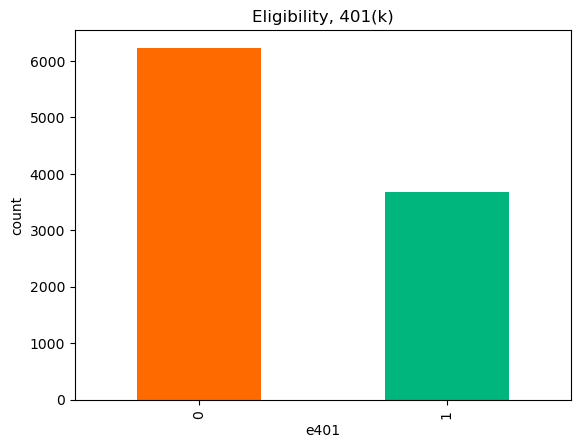

In [6]:
data['e401'].value_counts().plot(kind='bar', color= ['#FF6A00', '#00B67D'])
plt.title('Eligibility, 401(k)')
plt.xlabel('e401')
_ = plt.ylabel('count')

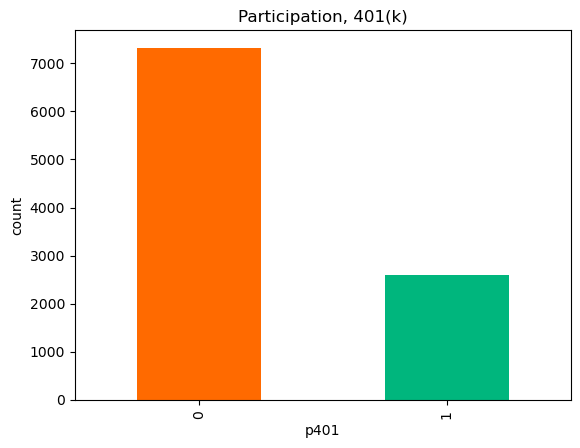

In [7]:
data['p401'].value_counts().plot(kind='bar', color= ['#FF6A00', '#00B67D'])
plt.title('Participation, 401(k)')
plt.xlabel('p401')
_ = plt.ylabel('count')

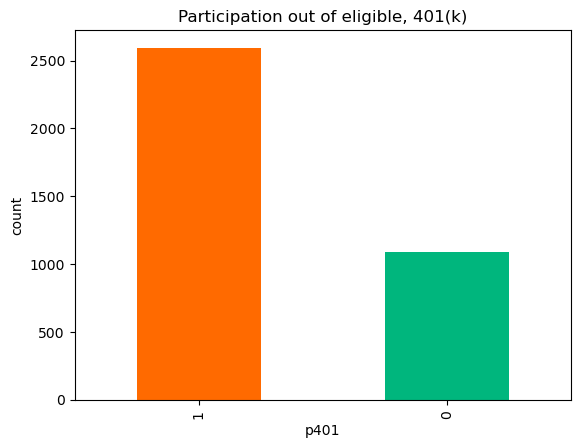

In [8]:
data[data['e401']==1]['p401'].value_counts().plot(kind='bar', color= ['#FF6A00', '#00B67D'])
plt.title('Participation out of eligible, 401(k)')
plt.xlabel('p401')
_ = plt.ylabel('count')

## Using base model with features as is

In [9]:
data.columns

Index(['nifa', 'net_tfa', 'tw', 'age', 'inc', 'fsize', 'educ', 'db', 'marr',
       'twoearn', 'e401', 'p401', 'pira', 'hown'],
      dtype='object')

<Axes: >

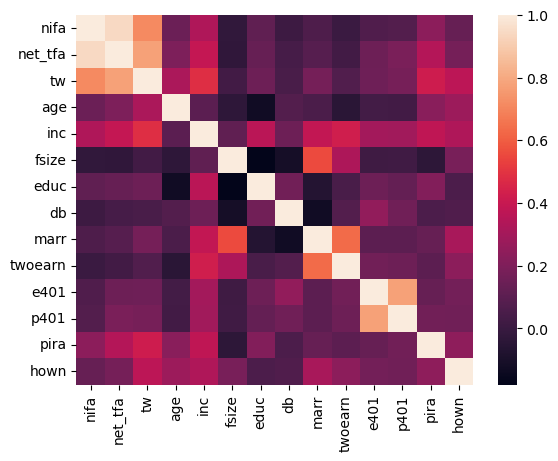

In [10]:
c=data.corr()
sns.heatmap(c)

In [11]:
# Set up basic model: Specify variables for data-backend
# nifa and tw seem to be highly correlated to net_tfa
features_base = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown']

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='net_tfa',
                                 d_cols='e401',
                                 x_cols=features_base)

## lasso and LogisticRegression

- ml_l: E(Y|X)
- ml_m: E(D|X)


Y= outcome
D= treatment
X= covariates

In [12]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000))
lasso_class = make_pipeline(StandardScaler(),
                            LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear',
                                                 Cs = Cs, max_iter=1000))

np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_lasso = dml.DoubleMLPLR(data_dml_base,
                                ml_l = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)
print(dml_plr_lasso.summary)

             coef      std err         t     P>|t|       2.5 %       97.5 %
e401  5722.460884  1380.579126  4.144971  0.000034  3016.57552  8428.346249


### How to interpret the results from summary-
coef: This is the estimated coefficient for the treatment variable e401, which quantifies the average causal effect of the treatment on the outcome variable. In your case, the coefficient value is 5722.460884, suggesting that, on average, the treatment leads to an increase of approximately 5722.46 in the outcome measure, holding other factors constant.

std err: The standard error (1380.579126) measures the variability or uncertainty in the estimated coefficient. A smaller standard error indicates more precision in the estimation of the coefficient.

t: This is the t-statistic (4.144971), calculated as the coefficient divided by its standard error. The t-statistic is used to determine whether the coefficient is significantly different from 0, with larger absolute values indicating stronger evidence against the null hypothesis (that there is no effect).

P>|t|: The p-value (0.000034) indicates the probability of observing the data, or something more extreme, if the null hypothesis were true. A small p-value (typically < 0.05) suggests that the observed effect is statistically significant, and we can reject the null hypothesis of no effect. In this case, the p-value is very small, indicating strong evidence against the null hypothesis.

2.5 % and 97.5 %: These are the lower and upper bounds of the 95% confidence interval ([3016.57552, 8428.346249]), respectively. This interval is a range of values that is likely to contain the true coefficient value with 95% certainty. Since this interval does not include 0, it further supports the conclusion that the treatment effect is statistically significant.

